# DuckDB + Spatial Extension Scalability Test
This notebook benchmarks the scalability of DuckDB Spatial using real city data from OpenStreetMap.
We test with increasing urban complexity: Pinerolo, Milano, Roma and Tokyo.

In [1]:
# Import libraries
import os
import time
import duckdb
import osmnx as ox
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="osmnx._overpass")

---

## Starting the main benchmark test

The test needs some nominal and type adjustments before its start.

We use overpass to get direct access to every OpenStreetMap data.

In [2]:
# Prepare DuckDB with spatial extension
con = duckdb.connect('data/benchmark/benchmark.duckdb')
con.execute("INSTALL spatial;")
con.execute("LOAD spatial;")

# Define cities to benchmark
cities = ["Pinerolo, Piemonte, Italy", "Milano, Lombardia, Italy", "Roma, Lazio, Italy", "Tokyo, Japan"]
results = []

# Normalize a city name to use as table suffix
def normalize_city_name(city):
    return city.lower().replace(",", "").replace(" ", "_")

For every city defined before we are going to get their polygon from OSM via osmnx and to convert their geometries to WKT (Well-Know Text = representing vector geometry objects).

Then we create the tables into the database for every city and we calculate every major information about the city loading (Number of Nodes, Number of Edges, Query Time, Memory Usage in the DataBase).

We even load every data found into a .csv file to analyze them better.

In [3]:
# Loop over each city to download, process, and insert data
for city in cities:
    print(f"\nProcessing {city}...")

    ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"
    table_suffix = normalize_city_name(city)

    try:
        # Get city polygon
        gdf = ox.geocode_to_gdf(city)
        polygon = gdf.loc[0, 'geometry']

        # Download street network
        G = ox.graph_from_polygon(polygon, network_type='drive')

        # Project the graph to a coordinate system with meters (e.g., UTM)
        G_projected = ox.project_graph(G)

        # Convert graph to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G_projected)

        # Convert geometries to WKT
        nodes['geometry_wkt'] = nodes['geometry'].apply(lambda geom: geom.wkt)
        edges['geometry_wkt'] = edges['geometry'].apply(lambda geom: geom.wkt)

        # Clean and register dataframes
        nodes_clean = nodes.drop(columns=['geometry']).copy()
        edges_clean = edges.drop(columns=['geometry']).copy()

        # Convert problematic columns (like arrays or mixed types) to strings
        for df in [nodes_clean, edges_clean]:
            for col in df.columns:
                if df[col].apply(lambda x: isinstance(x, list)).any():
                    df[col] = df[col].astype(str)

        con.register('nodes_df', nodes_clean)
        con.register('edges_df', edges_clean)

        # Create dedicated tables per city
        con.execute(f"""
            CREATE TABLE IF NOT EXISTS nodes_{table_suffix} AS
            SELECT ROW_NUMBER() OVER() AS node_id, * FROM nodes_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO nodes_{table_suffix}
            SELECT ROW_NUMBER() OVER() AS node_id, * FROM nodes_df;
        """)

        con.execute(f"""
            CREATE TABLE IF NOT EXISTS edges_{table_suffix} AS
            SELECT ROW_NUMBER() OVER() AS edge_id, * FROM edges_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO edges_{table_suffix}
            SELECT ROW_NUMBER() OVER() AS edge_id, * FROM edges_df;
        """)

        # Time spatial query for benchmark test (calculate avg, max and min length of the edges of any city)
        start = time.time()
        con.execute(f"""
            SELECT
                AVG(ST_Length(ST_GeomFromText(geometry_wkt))) AS avg_length,
                MAX(ST_Length(ST_GeomFromText(geometry_wkt))) AS max_length,
                MIN(ST_Length(ST_GeomFromText(geometry_wkt))) AS min_length
            FROM edges_{table_suffix}
            WHERE geometry_wkt IS NOT NULL;
        """)
        query_time = time.time() - start

        # Measure DB file size
        db_size = os.path.getsize("data/benchmark/benchmark.duckdb") / (1024 ** 2)  # MB

        # Save result
        results.append({
            'City': city,
            'Nodes': len(nodes),
            'Edges': len(edges),
            'Query Time (s)': round(query_time, 3),
            'DB Size (MB)': round(db_size, 2)
        })

    except Exception as e:
        print(f"Error processing {city}: {e}")

# Show results
summary = pd.DataFrame(results)
print(summary)

# Save summary to CSV
summary.to_csv("data/benchmark/duckdb_scalability_summary.csv", index=False)


Processing Pinerolo, Piemonte, Italy...

Processing Milano, Lombardia, Italy...

Processing Roma, Lazio, Italy...

Processing Tokyo, Japan...
                        City   Nodes   Edges  Query Time (s)  DB Size (MB)
0  Pinerolo, Piemonte, Italy    1155    2478           0.019          0.01
1   Milano, Lombardia, Italy   12898   25419           0.166          0.01
2         Roma, Lazio, Italy   43557   90240           0.671         49.76
3               Tokyo, Japan  237509  633282           0.729        149.51


We can clearly see the differences between a small city like Pinerolo and one of the biggest cities in the world like Tokyo: every data from Tokyo is bigger and more difficult to obtain.

Sometimes we even think Rome is gigantic, but Tokyo is 7 times bigger!

---

## Looking at the results

We can look at the results of the benchmark test via some graphs of different types.

                        City   Nodes   Edges  Query Time (s)  DB Size (MB)
0  Pinerolo, Piemonte, Italy    1155    2478           0.019          0.01
1   Milano, Lombardia, Italy   12898   25419           0.166          0.01
2         Roma, Lazio, Italy   43557   90240           0.671         49.76
3               Tokyo, Japan  237509  633282           0.729        149.51


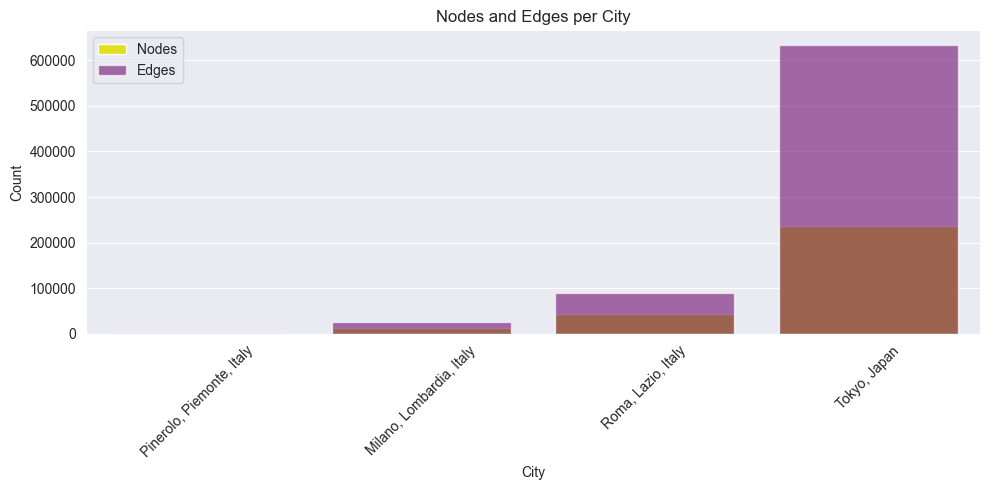

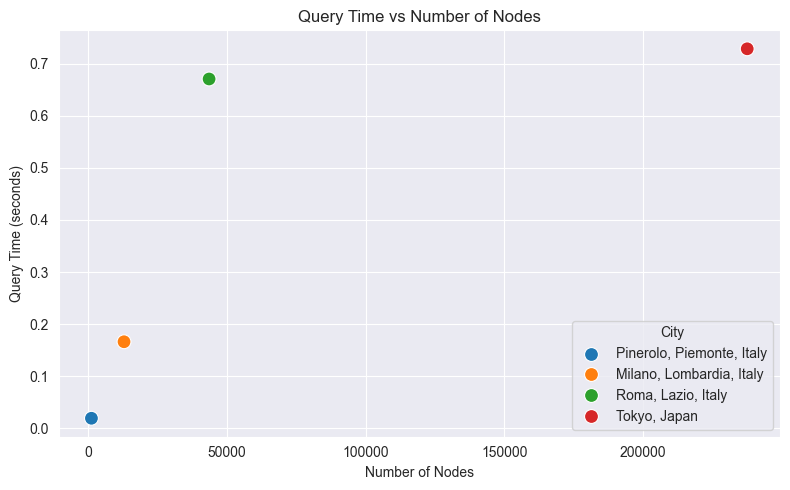

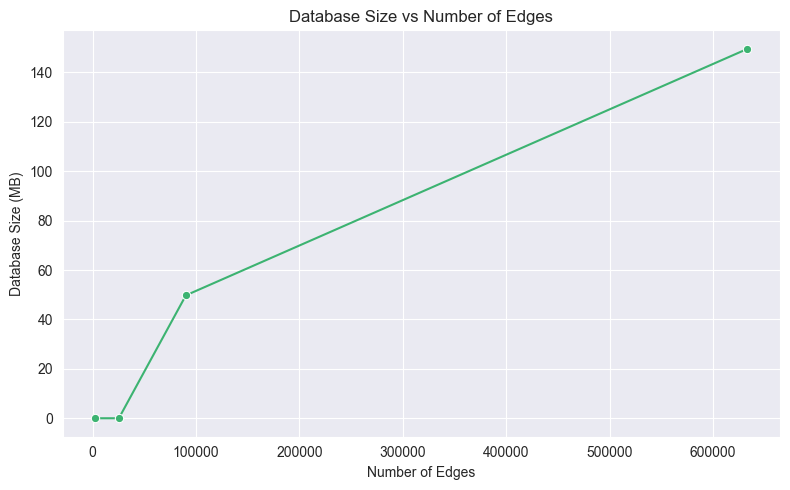

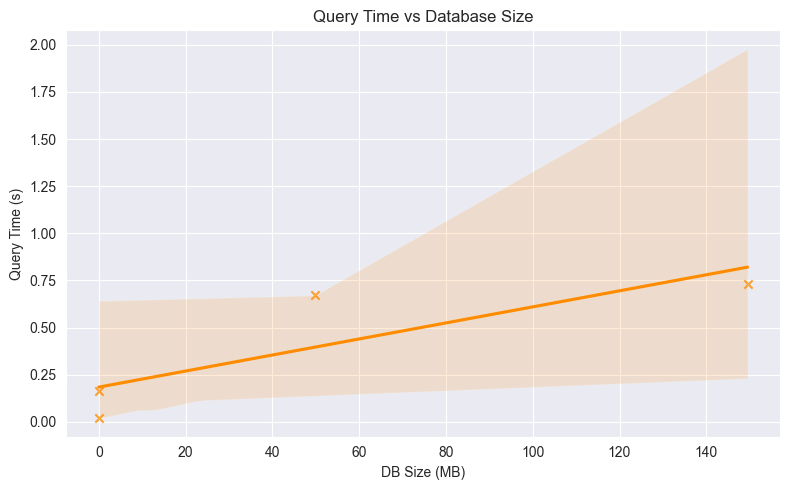

Correlation Matrix:
                   Nodes     Edges  Query Time (s)  DB Size (MB)
Nodes           1.000000  0.999282        0.740210      0.982420
Edges           0.999282  1.000000        0.714384      0.975698
Query Time (s)  0.740210  0.714384        1.000000      0.841055
DB Size (MB)    0.982420  0.975698        0.841055      1.000000


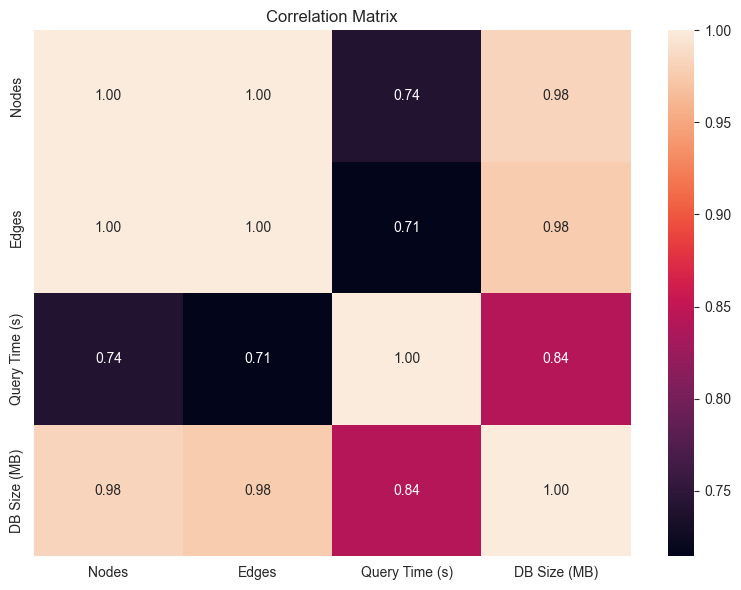

In [4]:
# Load results from CSV file
df = pd.read_csv("data/benchmark/duckdb_scalability_summary.csv")

# Display the content
print(df)

# Barplot: Nodes and Edges per City
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="City", y="Nodes", color='yellow', label="Nodes")
sns.barplot(data=df, x="City", y="Edges", color='purple', label="Edges", alpha=0.6)
plt.title("Nodes and Edges per City")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatterplot: Query Time vs Nodes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Nodes", y="Query Time (s)", hue="City", s=100)
plt.title("Query Time vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Query Time (seconds)")
plt.tight_layout()
plt.show()

# Lineplot: DB Size vs Edges
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Edges", y="DB Size (MB)", marker='o', color='mediumseagreen')
plt.title("Database Size vs Number of Edges")
plt.xlabel("Number of Edges")
plt.ylabel("Database Size (MB)")
plt.tight_layout()
plt.show()

# Regression plot: Query Time vs DB Size
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="DB Size (MB)", y="Query Time (s)", marker='x', color='darkorange')
plt.title("Query Time vs Database Size")
plt.tight_layout()
plt.show()

# Select numeric columns only
numeric_df = df[["Nodes", "Edges", "Query Time (s)", "DB Size (MB)"]]

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Print the matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

---

## Other test N1: Spatial Join Between Nodes and Edges

This benchmark evaluates the performance of a spatial join between the nodes and edges tables for a selected city.
We use the `ST_DWithin` function to check for proximity within 10 meters between node points and edge geometries.

This type of query is useful in applications such as routing, nearest neighbor searches, or mapping services.


In [5]:
# Milan test only
cities_to_test = ["Milano, Lombardia, Italy"]

for city in cities_to_test:
    print(f"Running spatial join benchmark for {city}...")

    table_suffix = normalize_city_name(city)

    # Function to check if a table exists in DuckDB
    def table_exists(conn, table_name):
        result = conn.execute(f"""
            SELECT COUNT(*)
            FROM duckdb_tables()
            WHERE table_name = '{table_name}'
        """).fetchone()
        return result[0] > 0

    # Table names for simplified geometries
    nodes_simplified = f"nodes_simplified_{table_suffix}"
    edges_simplified = f"edges_simplified_{table_suffix}"

    # Create simplified nodes table if it doesn't exist
    if not table_exists(con, nodes_simplified):
        con.execute(f"""
            CREATE TABLE {nodes_simplified} AS
            SELECT *, ST_Simplify(ST_GeomFromText(geometry_wkt), 0.00005) AS geom
            FROM nodes_{table_suffix};
        """)

    # Create simplified edges table if it doesn't exist
    if not table_exists(con, edges_simplified):
        con.execute(f"""
            CREATE TABLE {edges_simplified} AS
            SELECT *, ST_Simplify(ST_GeomFromText(geometry_wkt), 0.00005) AS geom
            FROM edges_{table_suffix};
        """)

    # Optimized spatial join using bounding box prefiltering
    query = f"""
    WITH candidates AS (
        SELECT
            ROW_NUMBER() OVER() AS node_id, -- Create a unique identifier for nodes
            ROW_NUMBER() OVER() AS edge_id, -- Create a unique identifier for edges
            n.x AS node_x,
            n.y AS node_y,
            e.ref AS edge_ref -- Assuming 'ref' is a useful column for edges
        FROM {nodes_simplified} AS n
        JOIN {edges_simplified} AS e
        ON ST_Intersects(ST_Envelope(n.geom), ST_Envelope(e.geom))
    )
    SELECT COUNT(*)
    FROM candidates
    JOIN {nodes_simplified} AS n ON candidates.node_x = n.x AND candidates.node_y = n.y
    JOIN {edges_simplified} AS e ON candidates.edge_ref = e.ref
    WHERE ST_DWithin(n.geom, e.geom, 0.0001)
    """

    # Measure execution time of the spatial join
    start = time.time()
    con.execute(query)
    join_time = time.time() - start

    print(f"Spatial join time for {city}: {round(join_time, 3)} seconds")

Running spatial join benchmark for Milano, Lombardia, Italy...
Spatial join time for Milano, Lombardia, Italy: 1112.346 seconds


The spatial join is clearly a complicated operation as just for a medium-sized city like Milan it takes about 18 minutes to compute.

We will make other tests for bigger cities.

---

## Other test N2: Average Edge Length per City

This benchmark computes the average length of road segments in each city.
It gives an idea of the spatial scale and granularity of the street network.


In [5]:
for city in cities:
    table_suffix = normalize_city_name(city)

    # SQL query to calculate the average edge length
    query = f"""
    SELECT AVG(
        CASE
            WHEN ST_Length(ST_GeomFromText(geometry_wkt)) > 1
            THEN ST_Length(ST_GeomFromText(geometry_wkt))
            ELSE NULL
        END
    ) AS avg_length
    FROM edges_{table_suffix}
    WHERE geometry_wkt IS NOT NULL
    """

    try:
        # Execute the query and fetch the first result (average length)
        result = con.execute(query).fetchone()[0]

        # Check if the result is None (no valid data)
        if result is None:
            print(f"Average edge length in {city}: No valid geometries found.")
        else:
            print(f"Average edge length in {city}: {round(result, 2)} meters")
    except Exception as e:
        print(f"Error processing {city}: {e}")

Average edge length in Pinerolo, Piemonte, Italy: 150.72 meters
Average edge length in Milano, Lombardia, Italy: 98.61 meters
Average edge length in Roma, Lazio, Italy: 124.6 meters
Average edge length in Tokyo, Japan: 68.72 meters


Found a solution for `NaN` values in Tokyo, we loaded every type of data regardless of its size and instead of using `ST_Length_Spheroid` we used in the correct manner `ST_Length`, which gives us all the correct AVG edge length of every city defined.

---

## Other test N3: Measuring Import Time

This test measures how long it takes to insert a city's data into DuckDB. This helps assess the cost of ingesting large-scale spatial datasets.


In [19]:
import_times = []

for city in cities:
    print(f"\nMeasuring import time for {city}...")
    table_suffix = normalize_city_name(city)

    ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"

    try:
        # Start timing
        start = time.time()

        # Get city polygon and network
        gdf = ox.geocode_to_gdf(city)
        polygon = gdf.loc[0, 'geometry']
        G = ox.graph_from_polygon(polygon, network_type='drive')

        nodes, edges = ox.graph_to_gdfs(G)

        # Convert geometry to WKT
        nodes['geometry_wkt'] = nodes['geometry'].apply(lambda geom: geom.wkt)
        edges['geometry_wkt'] = edges['geometry'].apply(lambda geom: geom.wkt)

        # Drop geometry column
        nodes_clean = nodes.drop(columns=['geometry']).copy()
        edges_clean = edges.drop(columns=['geometry']).copy()

        # Fix list-type columns
        for df in [nodes_clean, edges_clean]:
            for col in df.columns:
                if df[col].apply(lambda x: isinstance(x, list)).any():
                    df[col] = df[col].astype(str)

        # Register DataFrames
        con.register('nodes_df', nodes_clean)
        con.register('edges_df', edges_clean)

        # Drop tables if they exist
        con.execute(f"DROP TABLE IF EXISTS nodes_{table_suffix};")
        con.execute(f"DROP TABLE IF EXISTS edges_{table_suffix};")

        # Get column names
        nodes_cols = ", ".join(nodes_clean.columns)
        edges_cols = ", ".join(edges_clean.columns)

        # Create and insert
        con.execute(f"CREATE TABLE nodes_{table_suffix} AS SELECT {nodes_cols} FROM nodes_df;")
        con.execute(f"CREATE TABLE edges_{table_suffix} AS SELECT {edges_cols} FROM edges_df;")

        # Stop timing
        import_time = time.time() - start
        import_times.append((city, round(import_time, 2)))

    except Exception as e:
        print(f"Error during import for {city}: {e}")

# Show results
for city, seconds in import_times:
    print("")
    print(f"{city}: {seconds} seconds")


Measuring import time for Pinerolo, Piemonte, Italy...

Measuring import time for Milano, Lombardia, Italy...

Measuring import time for Roma, Lazio, Italy...

Measuring import time for Tokyo, Japan...

Pinerolo, Piemonte, Italy: 4.55 seconds

Milano, Lombardia, Italy: 37.3 seconds

Roma, Lazio, Italy: 136.02 seconds

Tokyo, Japan: 616.19 seconds


We can see how the import time change between small cities, medium cities, big cities and gigantic cities.

if the time jump from Milan to Rome seems large, the one from Rome to Tokyo seems almost infinite (in fact, to measure the data for all 4 cities it takes about 13 minutes).

---

## Other test N4: Bounding Box Filter on Edges Table

This test evaluates the performance of DuckDB Spatial when applying a spatial filter using a bounding box. We use the function `ST_Within` to select all edges (road segments) from the `edges_roma_lazio_italy` table that fall entirely inside a small polygon defined over a central area of Rome.

This type of filter is fundamental for tasks such as visualizing a portion of a city, local spatial analytics, or implementing interactive map queries. The geometry is stored in WKT format and converted back on-the-fly using `ST_GeomFromText`.

Even though DuckDB does not yet support spatial indexes, this benchmark shows how efficient its spatial functions can be, even for relatively large datasets.


In [21]:
# Define the target city and table suffix
city = "Roma, Lazio, Italy"
table_suffix = normalize_city_name(city)

# Define the bounding box polygon to use as spatial filter
bbox = "POLYGON((12.45 41.87, 12.55 41.87, 12.55 41.93, 12.45 41.93, 12.45 41.87))"

# Measure execution time of the spatial query using ST_Within
start = time.time()

# Execute spatial filter: select all edges within the bounding box
con.execute(f"""
    SELECT COUNT(*)
    FROM edges_{table_suffix}
    WHERE ST_Within(ST_GeomFromText(geometry_wkt), ST_GeomFromText('{bbox}'))
""")

# Compute time required for the spatial filter
bbox_time = time.time() - start

# Print result
print(f"Bounding box filter in {city}: {round(bbox_time, 3)} seconds")

Bounding box filter in Roma, Lazio, Italy: 0.711 seconds


pWe ran a bounding box filter on Rome and it took around 0.7 seconds. Not bad at all, especially considering the size of the city’s dataset. Even without fancy indexing, DuckDB handled it pretty well for basic spatial filtering tasks.